# purpose
- 事業×デバイス別に、時系列データから次営業日の売上額を予測するモデルを作成すること


# TODOs
- 売上・日付・休日フラグのデータ作成
- モデルに読み込ませる時系列データ（7:1）作成
- 学習データをLSTMに読み込ませて学習
- LSTMの性能評価
- 次営業日の売上額を予測

### 事業×デバイス別のデータ作成

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

You should consider upgrading via the 'pip install --upgrade pip' command.


In [3]:
df = pd.read_csv('train_data.csv').sort_values('dt')

In [4]:
df.head()

,dt,holiday_flg,day_of_week,biz_category,category,uu,nontax_amount,arppu
0,2017-02-05,False,7,動画,02.pc_only,41389,60285589,1456
1,2017-02-05,False,7,同人,02.pc_only,7998,11927867,1491
2,2017-02-05,False,7,その他,02.pc_only,9617,22590360,2349
3,2017-02-05,False,7,ライブコミュニケーション,03.sp_only,3235,9856820,3046
4,2017-02-05,False,7,その他,01.multi_device,802,577459,720


In [5]:
# 何日かを格納する列追加
df['date'] = 0

import datetime
for i in range(len(df)):
    time = datetime.datetime.strptime(df['dt'][i], "%Y-%m-%d")
    df['date'][i] = time.day
    
df.head()

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/ipykernel/__main__.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy


,dt,holiday_flg,day_of_week,biz_category,category,uu,nontax_amount,arppu,date
0,2017-02-05,False,7,動画,02.pc_only,41389,60285589,1456,5
1,2017-02-05,False,7,同人,02.pc_only,7998,11927867,1491,5
2,2017-02-05,False,7,その他,02.pc_only,9617,22590360,2349,5
3,2017-02-05,False,7,ライブコミュニケーション,03.sp_only,3235,9856820,3046,5
4,2017-02-05,False,7,その他,01.multi_device,802,577459,720,5


In [6]:
# 事業部別にデータを分割するためのリストを作成
biz_category_list = list(set(df['biz_category']))
print(biz_category_list)
data_list_tmp = [df[df['biz_category'] == biz_category] for biz_category in biz_category_list]

['同人', '動画', 'ライブコミュニケーション', 'ゲーム', '電子書籍', 'その他']


In [7]:
# デバイス別にデータを分割するためのリストを作成
device_category_list = list(set(df['category']))
print(device_category_list)

data_list = []
for device_category in device_category_list:
    for data in data_list_tmp:
        data_list.append(data[data['category'] == device_category].loc[:, ['dt', 'nontax_amount', 'date', 'holiday_flg']])

data_list[0].tail()

['01.multi_device', '02.pc_only', '03.sp_only']


,dt,nontax_amount,date,holiday_flg
18508,2018-06-18,122917,18,False
18533,2018-10-06,387709,6,False
18552,2018-11-13,159043,13,False
18568,2019-03-01,284718,1,False
18611,2019-09-11,268826,11,False


In [8]:
# 学習データ可視化する関数
def plot_sales(
    x, y, 
    category_list, data_list,
    num_biz_cotegory, num_device_category, line_width):

    ax_list = []

    for i in range(len(category_list)):
        ax_list.append(
            {
                'ax':fig.add_subplot(num_biz_cotegory, num_device_category, i + 1),
                'category':category_list[i],
                 'data':data_list[i]
                 }
            )

    for ax in ax_list:
        ax['ax'].tick_params(labelbottom='off')
        ax['ax'].set_title(ax['category'])
        ax['ax'].plot(x, y, data=ax['data'], linewidth=line_width)

In [9]:
category_list = []
for device_category in device_category_list:
    for biz_category in biz_category_list:
        category_list.append(biz_category + '_' + device_category)

/home/ec2-user/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


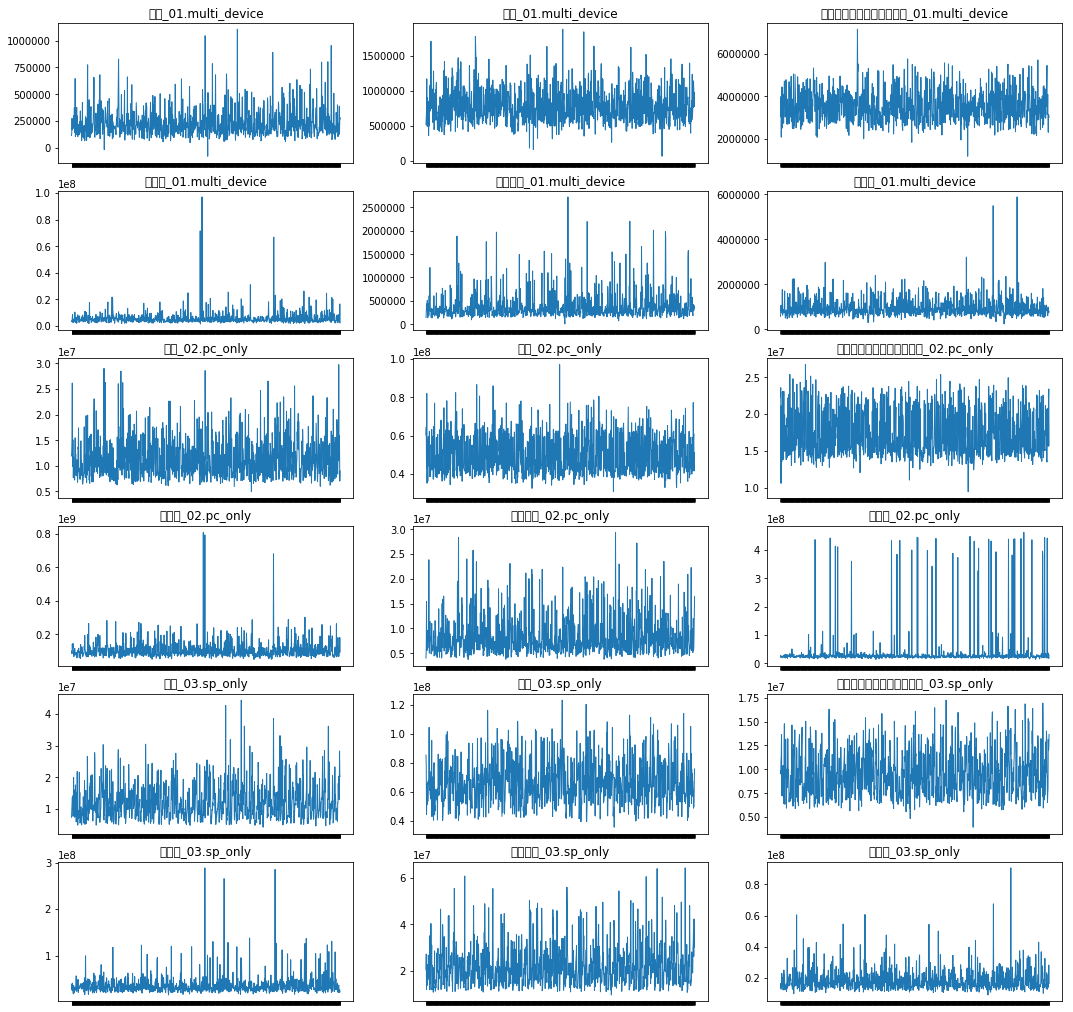

In [10]:
# 学習データ可視化
fig = plt.figure(figsize=(18, 18))

plot_sales('dt', 'nontax_amount', category_list, data_list, 6, 3, 1)

### モデルに読み込ませる時系列データ作成

In [11]:
import numpy as np
from sklearn.preprocessing import MinMaxScaler

np.random.seed(7)

In [12]:
# 入力に用いる変数のリストを作る
input_list = []

for device_category in device_category_list:
    for data in data_list_tmp:
        input_list.append(data[data['category'] == device_category].loc[:, ['nontax_amount', 'date', 'holiday_flg']])

In [13]:
input_df_list = []
for i in range(len(input_list)):
    input_df_list.append(pd.DataFrame(input_list[i]))
input_df_list[0].head()

,nontax_amount,date,holiday_flg
9,114013,17,False
33,139882,15,False
65,274147,18,False
78,166150,14,False
100,205461,5,False


In [14]:
# 前処理データを格納するリストを作成
scaler_list = []        
scaled_dataset_list = []

DIMENSSION = input_df_list[0].shape[1]
scaler = MinMaxScaler(feature_range=(0, 1))  # データを0~1に変換

for data in input_df_list:
    # データの前処理
    data = scaler.fit_transform(data)
    # 前処理したデータを格納
    scaler_list.append(scaler.fit(data.reshape(-1, DIMENSSION)))
    scaled_dataset_list.append(scaler.transform(data.reshape(-1, DIMENSSION)))

In [15]:
# データ整形関数
def series_to_supervised(data, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols = []
    names = []
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [(input_df_list[1].columns[j]+'(t-%d)' % (i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [(input_df_list[1].columns[j]+'(t)') for j in range(n_vars)]
        else:
            names += [(input_df_list[1].columns[j]+'(t+%d)' % (i)) for j in range(n_vars)]
            
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        agg.dropna(inplace=True)
    return agg

In [16]:
# データ整形
LENGTH_PER_UNIT = 7
reframed_dataset_list =  [series_to_supervised(scaled_dataset, LENGTH_PER_UNIT, 1) for scaled_dataset in scaled_dataset_list]
reframed_dataset_list

# 予測したくないデータの削除
DELETE_COLUMN = LENGTH_PER_UNIT*3 +1
reframed_list = []
for dataset in reframed_dataset_list:
    reframed_list.append(dataset.drop(dataset.columns[DELETE_COLUMN:], axis=1))
reframed_list[0].head()

,nontax_amount(t-7),date(t-7),holiday_flg(t-7),nontax_amount(t-6),date(t-6),holiday_flg(t-6),nontax_amount(t-5),date(t-5),holiday_flg(t-5),nontax_amount(t-4),...,nontax_amount(t-3),date(t-3),holiday_flg(t-3),nontax_amount(t-2),date(t-2),holiday_flg(t-2),nontax_amount(t-1),date(t-1),holiday_flg(t-1),nontax_amount(t)
7,0.163460,0.533333,0.0,0.185241,0.466667,0.0,0.298290,0.566667,0.0,0.207359,...,0.240458,0.133333,0.0,0.224277,0.266667,0.0,0.217076,0.900000,0.0,0.255942
8,0.185241,0.466667,0.0,0.298290,0.566667,0.0,0.207359,0.433333,0.0,0.240458,...,0.224277,0.266667,0.0,0.217076,0.900000,0.0,0.255942,0.033333,0.0,0.247739
9,0.298290,0.566667,0.0,0.207359,0.433333,0.0,0.240458,0.133333,0.0,0.224277,...,0.217076,0.900000,0.0,0.255942,0.033333,0.0,0.247739,0.166667,0.0,0.320966
10,0.207359,0.433333,0.0,0.240458,0.133333,0.0,0.224277,0.266667,0.0,0.217076,...,0.255942,0.033333,0.0,0.247739,0.166667,0.0,0.320966,0.300000,0.0,0.227766
11,0.240458,0.133333,0.0,0.224277,0.266667,0.0,0.217076,0.900000,0.0,0.255942,...,0.247739,0.166667,0.0,0.320966,0.300000,0.0,0.227766,0.066667,0.0,0.381242


In [17]:
# データをtrainとtestに分ける
values_list = [data.values for data in reframed_list]

train_size = int(len(values_list[0]) * 0.67)  
test_size = len(values_list[0]) - train_size 

train_adjast_num = train_size%LENGTH_PER_UNIT
test_adjast_num = test_size%LENGTH_PER_UNIT

# train/testを分ける
train_list = [data[train_adjast_num:train_size,:] for data in values_list]
test_list = [data[train_size:len(data)-test_adjast_num,:] for data in values_list]

In [18]:
print(f'train_list: {np.array(train_list).shape}')
print(f'test_list: {np.array(test_list).shape}')

train_list: (18, 686, 22)
test_list: (18, 336, 22)


In [19]:
# input と　outputに分ける
train_x_list = [train_data[:, :-1] for train_data in train_list]
train_y_list = [train_data[:, -1] for train_data in train_list]
test_x_list = [test_data[:, :-1] for test_data in test_list]
test_y_list = [test_data[:, -1] for test_data in test_list]

In [20]:
# inputデータを 3D [samples, timesteps, features]に変形

train_x_list = [train_x.reshape((train_x.shape[0], LENGTH_PER_UNIT, DIMENSSION)) for train_x in train_x_list]
test_x_list = [test_x.reshape((test_x.shape[0], LENGTH_PER_UNIT, DIMENSSION)) for test_x in test_x_list]

print(train_x_list[0].shape, train_y_list[0].shape, test_x_list[0].shape, test_y_list[0].shape)

(686, 7, 3) (686,) (336, 7, 3) (336,)


### 学習データをLSTMに読み込ませて学習

In [ ]:
# LSTMの定義とfit
#!pip install --upgrade pip tensorboard
import math
from keras.models import Sequential
from keras.layers import Dense, Activation
from keras.layers import LSTM
from sklearn.metrics import mean_squared_error
from keras import optimizers

# 最適化手法の設定
opt = optimizers.Adam()

def build_model(x_train, y_train, x_test, y_test): 
    model = Sequential()
    # 隠れ層、LSTMに入力するデータの形を指定([バッチサイズ，step数，特徴の次元数]を指定する）
    model.add(LSTM(100, input_shape=(test_x_list[0].shape[1], train_x_list[0].shape[2])))
    model.add(Dense(1))
    model.add(Activation("linear"))
    # モデルのコンパイル
    model.compile(optimizer = opt,  # 最適化手法
                  loss = 'mean_squared_error',  # 損失関数
                  metrics = ['accuracy'])   # 評価関数
    
    model.fit(x_train, y_train, epochs=50, batch_size=5, validation_data=(x_test, y_test), verbose=1)
    
    return model

model_list = []

for i in range(len(category_list)):
    print(i)
    print(category_list[i])
    model_list.append(build_model(train_x_list[i], train_y_list[i], test_x_list[i], test_y_list[i]))
    print('')

Using TensorFlow backend.



0
同人_01.multi_device




Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



Train on 686 samples, validate on 336 samples
Epoch 1/50





686/686 [==============================] - 11s 16ms/step - loss: 0.0142 - acc: 0.0015 - val_loss: 0.0144 - val_acc: 0.0000e+00
Epoch 2/50
686/686 [==============================] - 7s 10ms/step - loss: 0.0126 - acc: 0.0015 - val_loss: 0.0134 - val_acc: 0.0000e+00
Epoch 3/50
686/686 [==============================] - 7s 10ms/step - loss: 0.0121 - acc: 0.0015 - val_loss: 0.0148 - val_acc: 0.0000e+00
Epoch 4/50
686/686 [==============================] - 7s 10ms/step - loss: 0.0121 - acc: 0.0015 - val_loss: 0.0134 - val_acc: 0.0000e+00
Epoch 5/50
686/686 [==============================] - 8s 11ms/step - loss: 0.0122 - acc: 0.0015 - val_loss: 0.0132 - val_acc: 0.0000e+00
Epoch 6/50
686/686 [==============================] - 7s 10ms/step - loss: 0.0124 - acc: 0.0015 - val_loss: 0.0131 - val_acc: 0.0000e+00
Epo

686/686 [==============================] - 8s 11ms/step - loss: 0.0115 - acc: 0.0015 - val_loss: 0.0132 - val_acc: 0.0000e+00
Epoch 37/50
686/686 [==============================] - 7s 11ms/step - loss: 0.0117 - acc: 0.0015 - val_loss: 0.0135 - val_acc: 0.0000e+00
Epoch 38/50
686/686 [==============================] - 7s 10ms/step - loss: 0.0114 - acc: 0.0015 - val_loss: 0.0132 - val_acc: 0.0000e+00
Epoch 39/50
686/686 [==============================] - 7s 10ms/step - loss: 0.0115 - acc: 0.0015 - val_loss: 0.0138 - val_acc: 0.0000e+00
Epoch 40/50
686/686 [==============================] - 7s 11ms/step - loss: 0.0115 - acc: 0.0015 - val_loss: 0.0133 - val_acc: 0.0000e+00
Epoch 41/50
686/686 [==============================] - 7s 11ms/step - loss: 0.0115 - acc: 0.0015 - val_loss: 0.0133 - val_acc: 0.0000e+00
Epoch 42/50
686/686 [==============================] - 7s 10ms/step - loss: 0.0115 - acc: 0.0015 - val_loss: 0.0134 - val_acc: 0.0000e+00
Epoch 43/50
686/686 [=========================

686/686 [==============================] - 7s 11ms/step - loss: 0.0185 - acc: 0.0000e+00 - val_loss: 0.0175 - val_acc: 0.0030
Epoch 46/50
686/686 [==============================] - 7s 10ms/step - loss: 0.0186 - acc: 0.0000e+00 - val_loss: 0.0177 - val_acc: 0.0030
Epoch 47/50
686/686 [==============================] - 7s 10ms/step - loss: 0.0185 - acc: 0.0000e+00 - val_loss: 0.0178 - val_acc: 0.0030
Epoch 48/50
686/686 [==============================] - 7s 10ms/step - loss: 0.0187 - acc: 0.0000e+00 - val_loss: 0.0176 - val_acc: 0.0030
Epoch 49/50
686/686 [==============================] - 7s 10ms/step - loss: 0.0186 - acc: 0.0000e+00 - val_loss: 0.0176 - val_acc: 0.0030
Epoch 50/50
686/686 [==============================] - 7s 11ms/step - loss: 0.0186 - acc: 0.0000e+00 - val_loss: 0.0179 - val_acc: 0.0030

2
ライブコミュニケーション_01.multi_device
Train on 686 samples, validate on 336 samples
Epoch 1/50
686/686 [==============================] - 11s 16ms/step - loss: 0.0189 - acc: 0.0000e+00 - val

686/686 [==============================] - 3s 5ms/step - loss: 0.0032 - acc: 0.0015 - val_loss: 0.0028 - val_acc: 0.0000e+00
Epoch 4/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0031 - acc: 0.0015 - val_loss: 0.0029 - val_acc: 0.0000e+00
Epoch 5/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0032 - acc: 0.0015 - val_loss: 0.0028 - val_acc: 0.0000e+00
Epoch 6/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0032 - acc: 0.0015 - val_loss: 0.0028 - val_acc: 0.0000e+00
Epoch 7/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0031 - acc: 0.0015 - val_loss: 0.0027 - val_acc: 0.0000e+00
Epoch 8/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0032 - acc: 0.0015 - val_loss: 0.0028 - val_acc: 0.0000e+00
Epoch 9/50
686/686 [==============================] - 4s 6ms/step - loss: 0.0032 - acc: 0.0015 - val_loss: 0.0028 - val_acc: 0.0000e+00
Epoch 10/50
686/686 [==============================] - 3s 5

686/686 [==============================] - 4s 5ms/step - loss: 0.0100 - acc: 0.0015 - val_loss: 0.0135 - val_acc: 0.0000e+00
Epoch 13/50
686/686 [==============================] - 4s 6ms/step - loss: 0.0099 - acc: 0.0015 - val_loss: 0.0135 - val_acc: 0.0000e+00
Epoch 14/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0099 - acc: 0.0015 - val_loss: 0.0135 - val_acc: 0.0000e+00
Epoch 15/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0100 - acc: 0.0015 - val_loss: 0.0132 - val_acc: 0.0000e+00
Epoch 16/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0099 - acc: 0.0015 - val_loss: 0.0136 - val_acc: 0.0000e+00
Epoch 17/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0099 - acc: 0.0015 - val_loss: 0.0139 - val_acc: 0.0000e+00
Epoch 18/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0099 - acc: 0.0015 - val_loss: 0.0134 - val_acc: 0.0000e+00
Epoch 19/50
686/686 [==============================] 

686/686 [==============================] - 3s 5ms/step - loss: 0.0041 - acc: 0.0000e+00 - val_loss: 0.0087 - val_acc: 0.0030
Epoch 22/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0040 - acc: 0.0000e+00 - val_loss: 0.0086 - val_acc: 0.0030
Epoch 23/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0041 - acc: 0.0000e+00 - val_loss: 0.0086 - val_acc: 0.0030
Epoch 24/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0040 - acc: 0.0000e+00 - val_loss: 0.0087 - val_acc: 0.0030
Epoch 25/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0040 - acc: 0.0000e+00 - val_loss: 0.0086 - val_acc: 0.0030
Epoch 26/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0041 - acc: 0.0000e+00 - val_loss: 0.0087 - val_acc: 0.0030
Epoch 27/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0040 - acc: 0.0000e+00 - val_loss: 0.0086 - val_acc: 0.0030
Epoch 28/50
686/686 [==============================] 

686/686 [==============================] - 3s 5ms/step - loss: 0.0237 - acc: 0.0015 - val_loss: 0.0256 - val_acc: 0.0000e+00
Epoch 31/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0234 - acc: 0.0015 - val_loss: 0.0264 - val_acc: 0.0000e+00
Epoch 32/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0235 - acc: 0.0015 - val_loss: 0.0259 - val_acc: 0.0000e+00
Epoch 33/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0233 - acc: 0.0015 - val_loss: 0.0263 - val_acc: 0.0000e+00
Epoch 34/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0233 - acc: 0.0015 - val_loss: 0.0257 - val_acc: 0.0000e+00
Epoch 35/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0234 - acc: 0.0015 - val_loss: 0.0255 - val_acc: 0.0000e+00
Epoch 36/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0233 - acc: 0.0015 - val_loss: 0.0264 - val_acc: 0.0000e+00
Epoch 37/50
686/686 [==============================] 

686/686 [==============================] - 3s 5ms/step - loss: 0.0254 - acc: 0.0000e+00 - val_loss: 0.0233 - val_acc: 0.0030
Epoch 40/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0251 - acc: 0.0000e+00 - val_loss: 0.0240 - val_acc: 0.0030
Epoch 41/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0252 - acc: 0.0000e+00 - val_loss: 0.0233 - val_acc: 0.0030
Epoch 42/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0249 - acc: 0.0000e+00 - val_loss: 0.0236 - val_acc: 0.0030
Epoch 43/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0252 - acc: 0.0000e+00 - val_loss: 0.0232 - val_acc: 0.0030
Epoch 44/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0251 - acc: 0.0000e+00 - val_loss: 0.0232 - val_acc: 0.0030
Epoch 45/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0251 - acc: 0.0000e+00 - val_loss: 0.0237 - val_acc: 0.0030
Epoch 46/50
686/686 [==============================] 

Epoch 49/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0344 - acc: 0.0015 - val_loss: 0.0316 - val_acc: 0.0030
Epoch 50/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0348 - acc: 0.0000e+00 - val_loss: 0.0319 - val_acc: 0.0030

9
ゲーム_02.pc_only
Train on 686 samples, validate on 336 samples
Epoch 1/50
686/686 [==============================] - 8s 12ms/step - loss: 0.0057 - acc: 0.0000e+00 - val_loss: 0.0052 - val_acc: 0.0030
Epoch 2/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0052 - acc: 0.0000e+00 - val_loss: 0.0049 - val_acc: 0.0030
Epoch 3/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0052 - acc: 0.0000e+00 - val_loss: 0.0049 - val_acc: 0.0030
Epoch 4/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0052 - acc: 0.0000e+00 - val_loss: 0.0049 - val_acc: 0.0030
Epoch 5/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0051 - acc: 0.0000e+00 - val_loss: 0.0049 - v

Epoch 8/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0236 - acc: 0.0015 - val_loss: 0.0249 - val_acc: 0.0000e+00
Epoch 9/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0237 - acc: 0.0015 - val_loss: 0.0250 - val_acc: 0.0000e+00
Epoch 10/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0237 - acc: 0.0015 - val_loss: 0.0248 - val_acc: 0.0000e+00
Epoch 11/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0235 - acc: 0.0015 - val_loss: 0.0248 - val_acc: 0.0000e+00
Epoch 12/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0235 - acc: 0.0015 - val_loss: 0.0249 - val_acc: 0.0000e+00
Epoch 13/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0235 - acc: 0.0015 - val_loss: 0.0253 - val_acc: 0.0000e+00
Epoch 14/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0236 - acc: 0.0015 - val_loss: 0.0257 - val_acc: 0.0000e+00
Epoch 15/50
686/686 [======================

686/686 [==============================] - 7s 10ms/step - loss: 0.0172 - acc: 0.0015 - val_loss: 0.0409 - val_acc: 0.0000e+00
Epoch 18/50
686/686 [==============================] - 8s 11ms/step - loss: 0.0173 - acc: 0.0015 - val_loss: 0.0414 - val_acc: 0.0000e+00
Epoch 19/50
686/686 [==============================] - 7s 10ms/step - loss: 0.0172 - acc: 0.0015 - val_loss: 0.0416 - val_acc: 0.0000e+00
Epoch 20/50
686/686 [==============================] - 7s 11ms/step - loss: 0.0171 - acc: 0.0015 - val_loss: 0.0420 - val_acc: 0.0000e+00
Epoch 21/50
686/686 [==============================] - 7s 11ms/step - loss: 0.0172 - acc: 0.0015 - val_loss: 0.0420 - val_acc: 0.0000e+00
Epoch 22/50
686/686 [==============================] - 7s 10ms/step - loss: 0.0172 - acc: 0.0015 - val_loss: 0.0410 - val_acc: 0.0000e+00
Epoch 23/50
686/686 [==============================] - 8s 11ms/step - loss: 0.0172 - acc: 0.0015 - val_loss: 0.0408 - val_acc: 0.0000e+00
Epoch 24/50
686/686 [=========================

686/686 [==============================] - 7s 10ms/step - loss: 0.0164 - acc: 0.0000e+00 - val_loss: 0.0177 - val_acc: 0.0030
Epoch 27/50
686/686 [==============================] - 7s 10ms/step - loss: 0.0165 - acc: 0.0000e+00 - val_loss: 0.0173 - val_acc: 0.0030
Epoch 28/50
686/686 [==============================] - 7s 10ms/step - loss: 0.0163 - acc: 0.0000e+00 - val_loss: 0.0175 - val_acc: 0.0030
Epoch 29/50
686/686 [==============================] - 7s 11ms/step - loss: 0.0162 - acc: 0.0000e+00 - val_loss: 0.0172 - val_acc: 0.0030
Epoch 30/50
686/686 [==============================] - 7s 10ms/step - loss: 0.0162 - acc: 0.0000e+00 - val_loss: 0.0170 - val_acc: 0.0030
Epoch 31/50
686/686 [==============================] - 7s 11ms/step - loss: 0.0162 - acc: 0.0000e+00 - val_loss: 0.0174 - val_acc: 0.0030
Epoch 32/50
686/686 [==============================] - 7s 11ms/step - loss: 0.0160 - acc: 0.0000e+00 - val_loss: 0.0171 - val_acc: 0.0030
Epoch 33/50
686/686 [=========================

686/686 [==============================] - 3s 5ms/step - loss: 0.0250 - acc: 0.0000e+00 - val_loss: 0.0307 - val_acc: 0.0030
Epoch 36/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0249 - acc: 0.0000e+00 - val_loss: 0.0305 - val_acc: 0.0030
Epoch 37/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0249 - acc: 0.0000e+00 - val_loss: 0.0327 - val_acc: 0.0030
Epoch 38/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0250 - acc: 0.0015 - val_loss: 0.0319 - val_acc: 0.0030
Epoch 39/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0246 - acc: 0.0000e+00 - val_loss: 0.0322 - val_acc: 0.0030
Epoch 40/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0252 - acc: 0.0000e+00 - val_loss: 0.0311 - val_acc: 0.0030
Epoch 41/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0246 - acc: 0.0015 - val_loss: 0.0322 - val_acc: 0.0030
Epoch 42/50
686/686 [==============================] - 3s 5ms

686/686 [==============================] - 3s 5ms/step - loss: 0.0248 - acc: 0.0000e+00 - val_loss: 0.0316 - val_acc: 0.0030
Epoch 45/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0243 - acc: 0.0015 - val_loss: 0.0341 - val_acc: 0.0030
Epoch 46/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0247 - acc: 0.0000e+00 - val_loss: 0.0325 - val_acc: 0.0030
Epoch 47/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0245 - acc: 0.0015 - val_loss: 0.0337 - val_acc: 0.0030
Epoch 48/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0244 - acc: 0.0000e+00 - val_loss: 0.0320 - val_acc: 0.0030
Epoch 49/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0241 - acc: 0.0000e+00 - val_loss: 0.0321 - val_acc: 0.0030
Epoch 50/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0242 - acc: 0.0000e+00 - val_loss: 0.0329 - val_acc: 0.0030

15
ゲーム_03.sp_only
Train on 686 samples, validate on 336 samp

686/686 [==============================] - 3s 5ms/step - loss: 0.0227 - acc: 0.0000e+00 - val_loss: 0.0269 - val_acc: 0.0030
Epoch 4/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0226 - acc: 0.0000e+00 - val_loss: 0.0259 - val_acc: 0.0030
Epoch 5/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0223 - acc: 0.0000e+00 - val_loss: 0.0273 - val_acc: 0.0030
Epoch 6/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0225 - acc: 0.0000e+00 - val_loss: 0.0256 - val_acc: 0.0030
Epoch 7/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0224 - acc: 0.0000e+00 - val_loss: 0.0254 - val_acc: 0.0030
Epoch 8/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0222 - acc: 0.0000e+00 - val_loss: 0.0257 - val_acc: 0.0030
Epoch 9/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0222 - acc: 0.0000e+00 - val_loss: 0.0255 - val_acc: 0.0030
Epoch 10/50
686/686 [==============================] - 3s 5

686/686 [==============================] - 3s 5ms/step - loss: 0.0064 - acc: 0.0000e+00 - val_loss: 0.0089 - val_acc: 0.0030
Epoch 13/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0063 - acc: 0.0000e+00 - val_loss: 0.0088 - val_acc: 0.0030
Epoch 14/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0064 - acc: 0.0000e+00 - val_loss: 0.0087 - val_acc: 0.0030
Epoch 15/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0063 - acc: 0.0000e+00 - val_loss: 0.0087 - val_acc: 0.0030
Epoch 16/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0063 - acc: 0.0000e+00 - val_loss: 0.0089 - val_acc: 0.0030
Epoch 17/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0064 - acc: 0.0000e+00 - val_loss: 0.0087 - val_acc: 0.0030
Epoch 18/50
686/686 [==============================] - 3s 5ms/step - loss: 0.0063 - acc: 0.0000e+00 - val_loss: 0.0088 - val_acc: 0.0030
Epoch 19/50
686/686 [==============================] 

### LSTMの性能評価

In [ ]:
# 予測
train_predict_list = []
test_predict_list = []
for i in range(len(category_list)):
    train_predict_list.append(model_list[i].predict(train_x_list[i]))
    test_predict_list.append(model_list[i].predict(test_x_list[i]))

In [ ]:
# データセットを同じ形にする
def pad_array(val):
    rescaled_val = [np.insert(pad_col, 0, x) for x in val]
    a = np.array(rescaled_val)
    return a

# 前処理したデータを元に戻す
rescaled_train_predict_list = []
rescaled_train_y_list = []
rescaled_test_predict_list = []
rescaled_test_y_list = []

for i in range(len(category_list)):
    rescaled_train_predict_list.append(scaler_list[i].inverse_transform(pad_array(train_predict_list[i])))
    rescaled_test_predict_list.append(scaler_list[i].inverse_transform(pad_array(test_predict_list[i])))
    
    rescaled_train_y_list.append(scaler_list[i].inverse_transform(pad_array(train_y_list[i])))
    rescaled_test_y_list.append(scaler_list[i].inverse_transform(pad_array(test_y_list[i])))

In [ ]:
# 二乗平均誤差を計算する　
train_score_list = []
test_score_list = []

for i in range(len(category_list)):
    train_score_list.append(math.sqrt(mean_squared_error(rescaled_train_y_list[i][:, 0], rescaled_train_predict_list[i][:,0])))
    test_score_list.append(math.sqrt(mean_squared_error(rescaled_test_y_list[i][:, 0], rescaled_test_predict_list[i][:,0])))

In [ ]:
# 最終的な誤差の平均
loss_av = 0
val_loss_av = 0
for i in range(len(category_list)):
    loss_av += model_list[i].history.history['loss'][49]
    val_loss_av += model_list[i].history.history['val_loss'][49]

print(f'loss average:　{loss_av/len(category_list)}')
print(f'validation loss average:　{val_loss_av/len(category_list)}')

In [ ]:
# 誤差の平均
print(f'Train score Av: {sum(train_score_list)/len(train_score_list)}')
print(f'Test score Av: {sum(test_score_list)/len(test_score_list)}')

In [ ]:
# lossの推移
fig = plt.figure(figsize=(18, 18))
ax_list = []

for i in range(len(category_list)):
    ax_list.append(
        {
            'ax':fig.add_subplot(6, 3, i + 1),
            'category':category_list[i],
            'loss_data':model_list[i].history.history['loss'],
            'val_loss_data':model_list[i].history.history['val_loss']
                }
        )

for ax in ax_list:
    ax['ax'].tick_params(labelbottom='off')
    ax['ax'].set_title(ax['category'])
    ax['ax'].plot(ax['loss_data'], label='loss')
    ax['ax'].plot(ax['val_loss_data'], label='val_loss')
    ax['ax'].legend()

### 次の日の売上を予測

In [ ]:
for i in range(len(category_list)):
    print(f'''
    {category_list[i]} : 
       - Train 誤差: {train_score_list[i]}
       - Test 誤差: {test_score_list[i]}
       - 標準偏差: {data_list[i]['nontax_amount'].std()} 
    ''')
    
     # trainの予測データをプロットするために変換
    dataset = scaled_dataset_list[i]
    train_predict_plot = np.empty_like(dataset)
    train_predict_plot[:, :] = np.nan
    train_predict_plot[train_adjast_num:train_size,:] = rescaled_train_predict_list[i]
    #train_predict_plot[LENGTH_PER_UNIT:len(rescaled_train_predict_list[i])+LENGTH_PER_UNIT, :] = rescaled_train_predict_list[i]

    # testの予測データをプロットするために変換
    test_predict_plot = np.empty_like(dataset)
    test_predict_plot[:, :] = np.nan
    test_predict_plot[LENGTH_PER_UNIT+train_size:len(dataset)-test_adjast_num,:] = rescaled_test_predict_list[i]
    #test_predict_plot[len(rescaled_train_predict_list[i])+(LENGTH_PER_UNIT*2)+1:len(dataset)-1, :] = rescaled_test_predict_list[i]


    # 予測と元のデータをプロット

    plt.figure(figsize=(10, 6))
    plt.plot(scaler_list[i].inverse_transform(dataset))
    plt.plot(train_predict_plot)
    plt.plot(test_predict_plot)
    plt.show()

#### まとめ
- 事業×デバイス別に、前営業日の売上額から次営業日の売上額を予測するモデルを作った
- 2016-01-01~ 2019-10-31の期間のデータのうち前半2/3を学習データ、後半1/3を検証用データとして用いた
- 評価指標はRMSEを用いた
    - 精度：10^-2のオーダー